In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Final Transactions.csv')

In [94]:
df.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


In [3]:
df = df[df.TX_FRAUD_SCENARIO != 3]
df = df[df.TX_AMOUNT < 1100]

In [4]:
cols = ['TRANSACTION_ID','TX_DATETIME', 'CUSTOMER_ID','TX_AMOUNT','TX_FRAUD','TERMINAL_ID']
df = df[cols]

In [75]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TX_AMOUNT,TX_FRAUD,TERMINAL_ID
0,0,2023-01-01 00:00:31,596,533.07,0,3156
1,1,2023-01-01 00:02:10,4961,808.56,0,3412
3,3,2023-01-01 00:09:29,4128,620.65,0,8737
4,4,2023-01-01 00:10:34,927,490.66,0,9906
5,5,2023-01-01 00:10:45,568,401.17,0,8803


## Exploratory Data Analysis

In [5]:
df.CUSTOMER_ID.value_counts()

382     767
3864    762
775     754
1411    751
149     749
       ... 
1504      1
3801      1
2502      1
4821      1
3631      1
Name: CUSTOMER_ID, Length: 4988, dtype: int64

<AxesSubplot: >

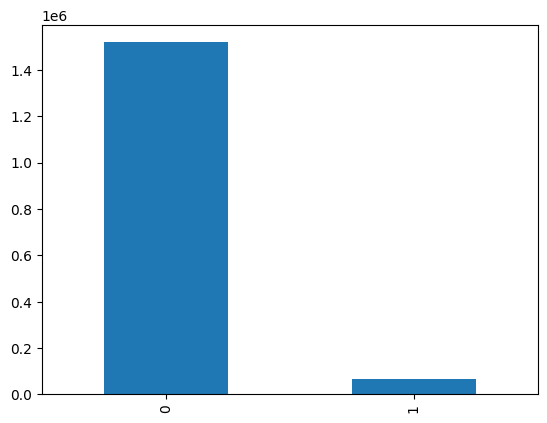

In [61]:
df.TX_FRAUD.value_counts().plot.bar()

In [62]:
df.TX_FRAUD.value_counts()

0    1518186
1      66599
Name: TX_FRAUD, dtype: int64

In [7]:
df.TX_DATETIME = pd.to_datetime(df.TX_DATETIME)

In [8]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TX_AMOUNT,TX_FRAUD,TERMINAL_ID
0,0,2023-01-01 00:00:31,596,533.07,0,3156
1,1,2023-01-01 00:02:10,4961,808.56,0,3412
3,3,2023-01-01 00:09:29,4128,620.65,0,8737
4,4,2023-01-01 00:10:34,927,490.66,0,9906
5,5,2023-01-01 00:10:45,568,401.17,0,8803


<AxesSubplot: >

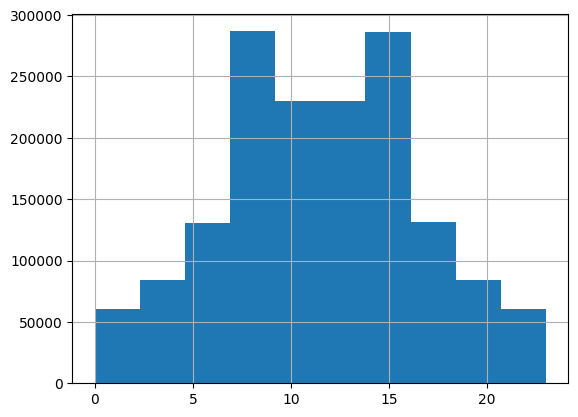

In [9]:
df['TX_DATETIME'].dt.hour.hist()

<AxesSubplot: >

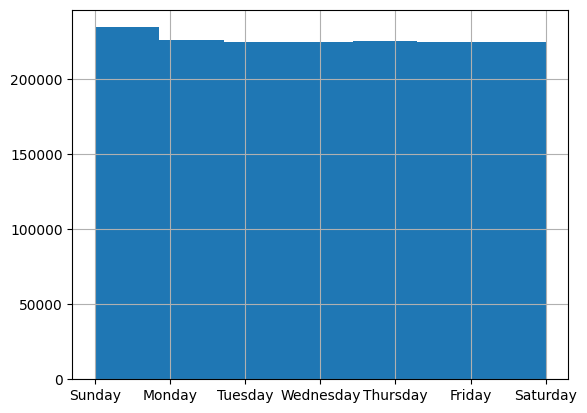

In [10]:
df['TX_DATETIME'].dt.day_name().hist(bins=7)

<AxesSubplot: >

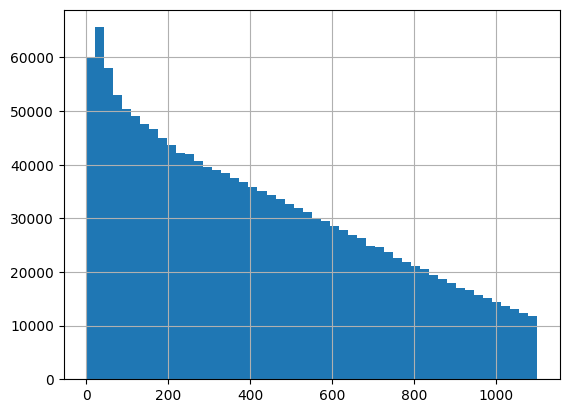

In [11]:
df.TX_AMOUNT.hist(bins=50)

<AxesSubplot: ylabel='TX_FRAUD'>

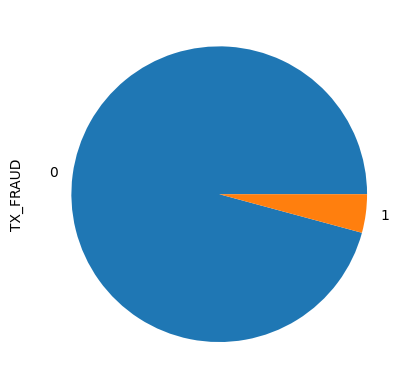

In [12]:
df.TX_FRAUD.value_counts().plot.pie()

## Feature Engineering

In [13]:
import featuretools as ft

In [14]:
cust_df = pd.DataFrame(df.CUSTOMER_ID.unique())
cust_df.columns = ['CUSTOMER_ID']
term_df = pd.DataFrame(df.TERMINAL_ID.unique())
term_df.columns = ['TERMINAL_ID']

In [15]:
es = ft.EntitySet(id='transactions')

In [16]:
es = es.add_dataframe(
    dataframe_name="transactions",
    dataframe=df.drop(['TX_FRAUD'],axis=1),
    index="TRANSACTION_ID",
    time_index="TX_DATETIME"
)

In [17]:
es = es.add_dataframe(
    dataframe_name="customers",
    dataframe=cust_df,
    index="CUSTOMER_ID"
)

In [18]:
es = es.add_dataframe(
    dataframe_name="terminals",
    dataframe=term_df,
    index="TERMINAL_ID"
)

In [19]:
es.add_relationship('customers','CUSTOMER_ID','transactions','CUSTOMER_ID')
es.add_relationship('terminals','TERMINAL_ID','transactions','TERMINAL_ID')

Entityset: transactions
  DataFrames:
    transactions [Rows: 1584785, Columns: 5]
    customers [Rows: 4988, Columns: 1]
    terminals [Rows: 10000, Columns: 1]
  Relationships:
    transactions.CUSTOMER_ID -> customers.CUSTOMER_ID
    transactions.TERMINAL_ID -> terminals.TERMINAL_ID

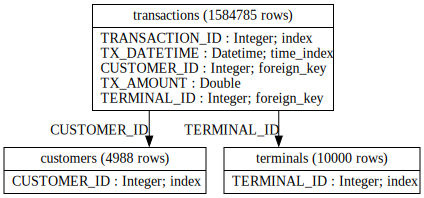

In [20]:
es.plot()

In [21]:
feature_matrix, defs = ft.dfs(
    entityset=es,
    target_dataframe_name="transactions",
    agg_primitives=["mean","max",'avg_time_between','time_since_last'],
    trans_primitives=['is_weekend','is_working_hours'],
    max_depth=2
)

In [22]:
feature_matrix.head()

,CUSTOMER_ID,TX_AMOUNT,TERMINAL_ID,IS_WEEKEND(TX_DATETIME),IS_WORKING_HOURS(TX_DATETIME),customers.AVG_TIME_BETWEEN(transactions.TX_DATETIME),customers.MAX(transactions.TX_AMOUNT),customers.MEAN(transactions.TX_AMOUNT),customers.TIME_SINCE_LAST(transactions.TX_DATETIME),terminals.AVG_TIME_BETWEEN(transactions.TX_DATETIME),terminals.MAX(transactions.TX_AMOUNT),terminals.MEAN(transactions.TX_AMOUNT),terminals.TIME_SINCE_LAST(transactions.TX_DATETIME)
TRANSACTION_ID,,,,,,,,,,,,,
0,596,533.07,3156,True,False,21066.250729,857.45,404.663459,2647.942382,122449.271186,994.02,391.463500,3864.942382
1,4961,808.56,3412,True,False,31467.364035,1096.92,694.862882,53713.942382,106184.500000,1068.00,456.460580,7726.942382
3,4128,620.65,8737,True,False,27270.607547,1078.53,546.575602,1122.942382,69289.240385,1059.07,400.245333,21752.942382
4,927,490.66,9906,True,False,32023.546667,1063.44,518.866416,22470.942382,144228.740000,1011.32,453.797059,16331.942382
5,568,401.17,8803,True,False,39530.344444,597.34,285.391381,112295.942382,101657.704225,1097.20,419.565556,10060.942382


In [23]:
cols = ['CUSTOMER_ID', 'TX_AMOUNT', 'TERMINAL_ID', 'weekend',
       'working_hours',
       'cust_avg_time_between',
       'cust_max_tx',
       'cust_mean_tx',
       'cust_time_since_last',
       'term_avg_time_between',
       'term_max_tx',
       'term_mean_tx',
       'term_time_since_last']
feature_matrix.columns = cols

In [24]:
res = feature_matrix.merge(df,how='left',right_on='TRANSACTION_ID',left_index=True)

In [25]:
drop_cols = ['CUSTOMER_ID_x', 'TERMINAL_ID_x', 'TRANSACTION_ID', 'TX_DATETIME',
       'CUSTOMER_ID_y', 'TX_AMOUNT_y', 'TERMINAL_ID_y']
res.drop(drop_cols,axis=1,inplace=True)

In [26]:
res.rename(columns={"TX_AMOUNT_x":"TX_AMOUNT"}, inplace=True)

In [27]:
res.cust_avg_time_between.fillna(res.cust_avg_time_between.mean(), inplace=True)

In [28]:
res.head()

,TX_AMOUNT,weekend,working_hours,cust_avg_time_between,cust_max_tx,cust_mean_tx,cust_time_since_last,term_avg_time_between,term_max_tx,term_mean_tx,term_time_since_last,TX_FRAUD
0,533.07,True,False,21066.250729,857.45,404.663459,2647.942382,122449.271186,994.02,391.463500,3864.942382,0
1,808.56,True,False,31467.364035,1096.92,694.862882,53713.942382,106184.500000,1068.00,456.460580,7726.942382,0
3,620.65,True,False,27270.607547,1078.53,546.575602,1122.942382,69289.240385,1059.07,400.245333,21752.942382,0
4,490.66,True,False,32023.546667,1063.44,518.866416,22470.942382,144228.740000,1011.32,453.797059,16331.942382,0
5,401.17,True,False,39530.344444,597.34,285.391381,112295.942382,101657.704225,1097.20,419.565556,10060.942382,0


In [65]:
res['cust_lag'] = res.cust_time_since_last / res.cust_avg_time_between
res['terminal_lag'] = res.term_time_since_last / res.term_avg_time_between
res['tx_ratio'] = res.TX_AMOUNT / res.cust_mean_tx

<AxesSubplot: >

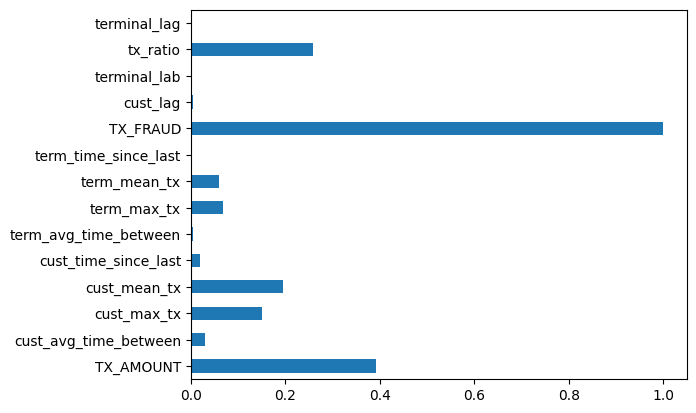

In [66]:
res.corrwith(res.TX_FRAUD).plot.barh()

In [71]:
X = res.drop(['TX_FRAUD'],axis=1)
y = res.TX_FRAUD

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

## Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, roc_auc_score

In [73]:
tree_model = DecisionTreeClassifier(ccp_alpha=0.001, class_weight={0:1,1:10})
tree_model = tree_model.fit(X_train,y_train)

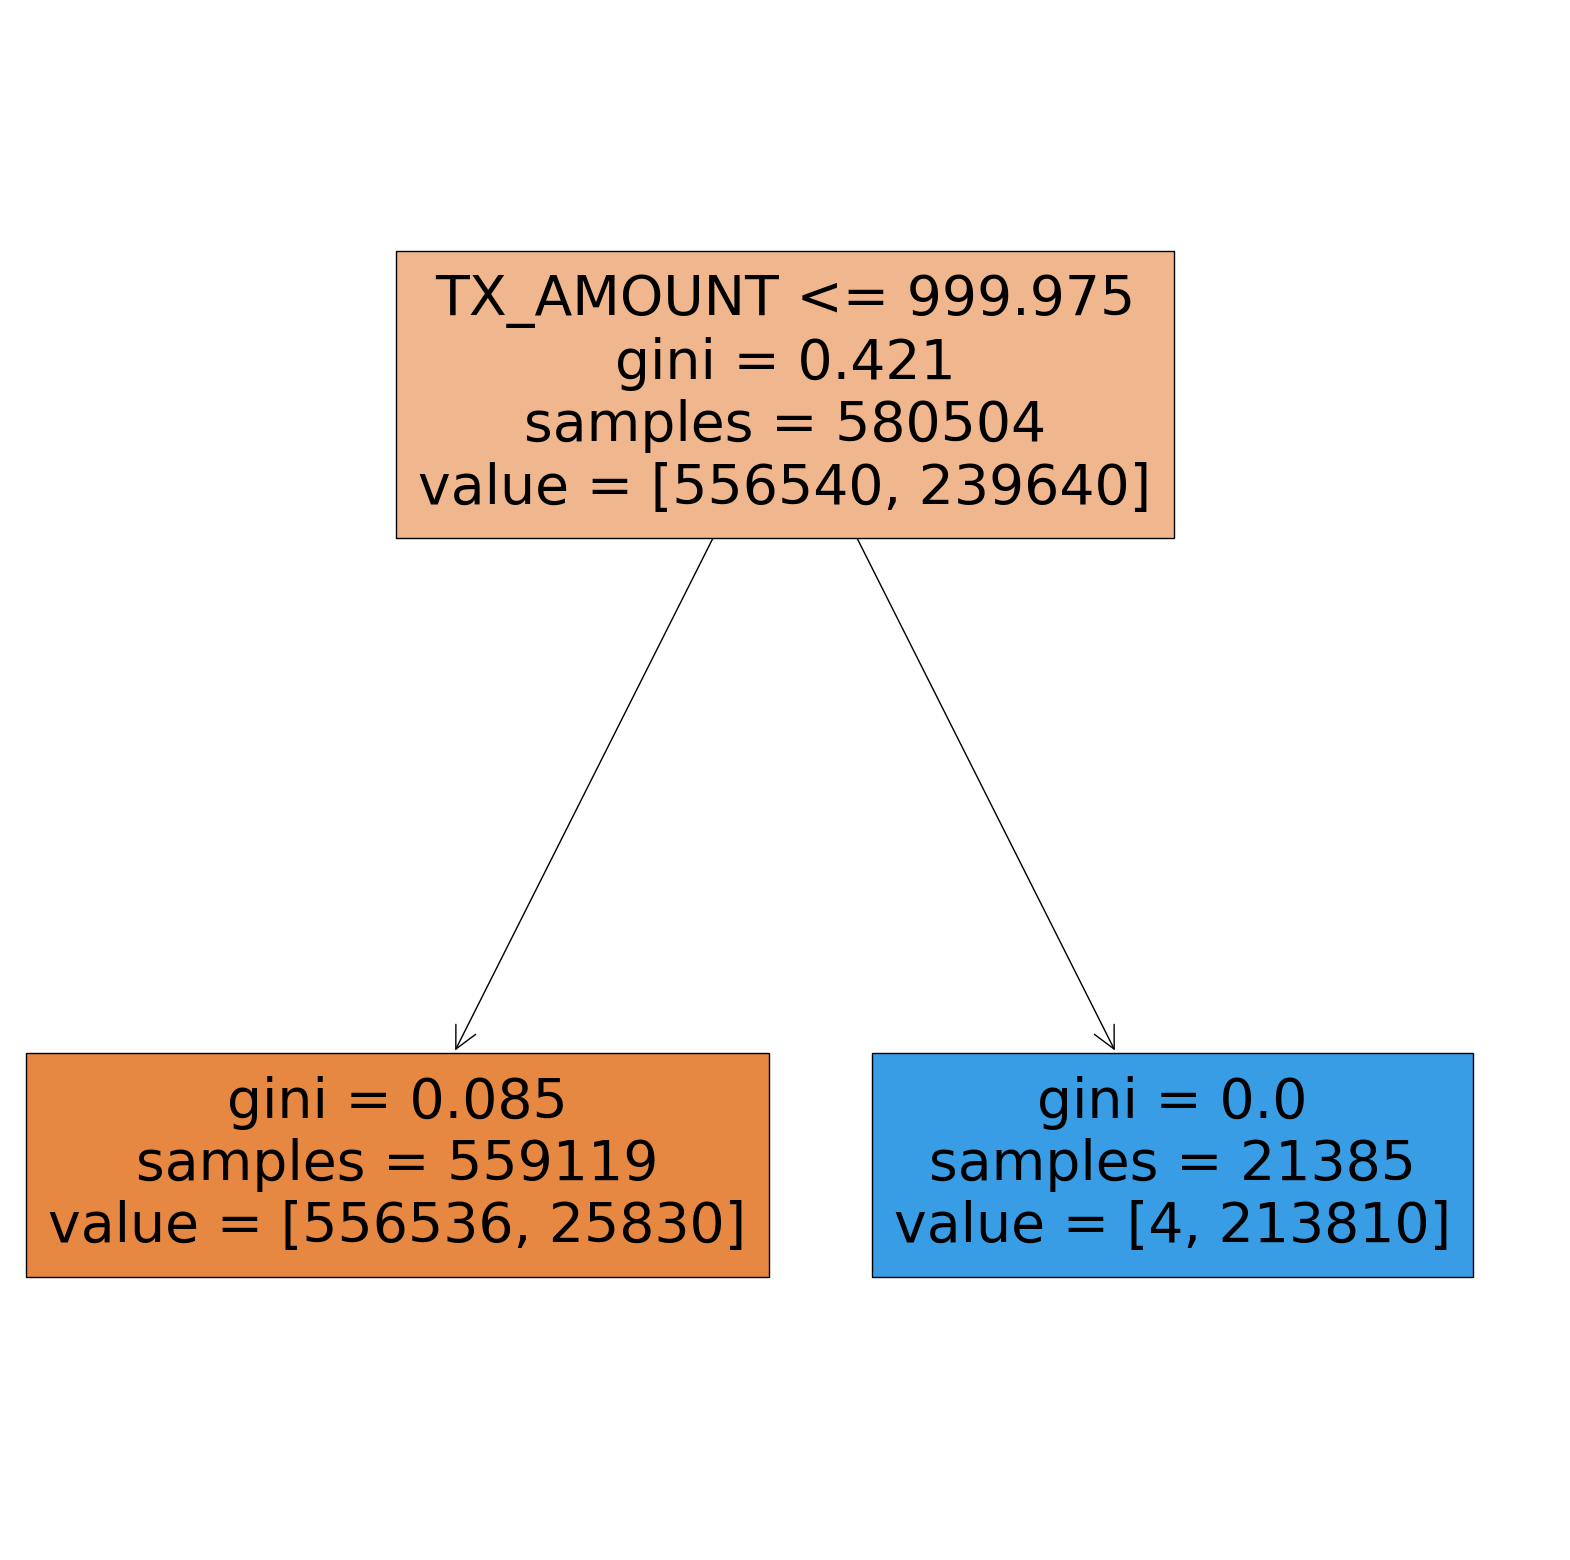

In [74]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(tree_model, filled=True,feature_names=X.columns)
plt.savefig('tree_diagram2.png')

In [51]:
y_pred = tree_model.predict(X_test)
y_proba = tree_model.predict_proba(X_test)[:,1]

In [50]:
f1_score(y_pred,y_test)

0.9464709501626088

In [52]:
roc_auc_score(y_test,y_proba)

0.9493334904190236

## Naive Bayes

In [54]:
from sklearn.naive_bayes import GaussianNB

In [55]:
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)
y_pred = nb_model.predict(X_test)
y_proba = nb_model.predict_proba(X_test)[:,1]

In [56]:
f1_score(y_pred,y_test)

0.41484955060570544

In [57]:
roc_auc_score(y_test,y_proba)

0.933062881177458

## XGBoost

In [34]:
from xgboost import XGBClassifier, plot_importance

In [35]:
eval_set=[(X_train, y_train), (X_test, y_test)]

In [58]:
xg_model = XGBClassifier(subsample=0.9)
xg_model.fit(X_train, y_train,eval_set=eval_set, eval_metric=["auc"],
            early_stopping_rounds=20)
y_pred = xg_model.predict(X_test)

C:\Python\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.95109	validation_1-auc:0.95462
[1]	validation_0-auc:0.95119	validation_1-auc:0.95469
[2]	validation_0-auc:0.95760	validation_1-auc:0.95962
[3]	validation_0-auc:0.96000	validation_1-auc:0.96335
[4]	validation_0-auc:0.96206	validation_1-auc:0.96348
[5]	validation_0-auc:0.96319	validation_1-auc:0.96437
[6]	validation_0-auc:0.96388	validation_1-auc:0.96480
[7]	validation_0-auc:0.96899	validation_1-auc:0.96915
[8]	validation_0-auc:0.96811	validation_1-auc:0.96895
[9]	validation_0-auc:0.97382	validation_1-auc:0.97562
[10]	validation_0-auc:0.97646	validation_1-auc:0.97780
[11]	validation_0-auc:0.97759	validation_1-auc:0.97795
[12]	validation_0-auc:0.97875	validation_1-auc:0.97840
[13]	validation_0-auc:0.98014	validation_1-auc:0.98020
[14]	validation_0-auc:0.98298	validation_1-auc:0.98376
[15]	validation_0-auc:0.98511	validation_1-auc:0.98641
[16]	validation_0-auc:0.98703	validation_1-auc:0.98831
[17]	validation_0-auc:0.98815	validation_1-auc:0.98923
[18]	validation_0-au

In [46]:
f1_score(y_pred,y_test)

0.9438926642272173

In [59]:
y_proba = xg_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_proba)

0.9993573750858797

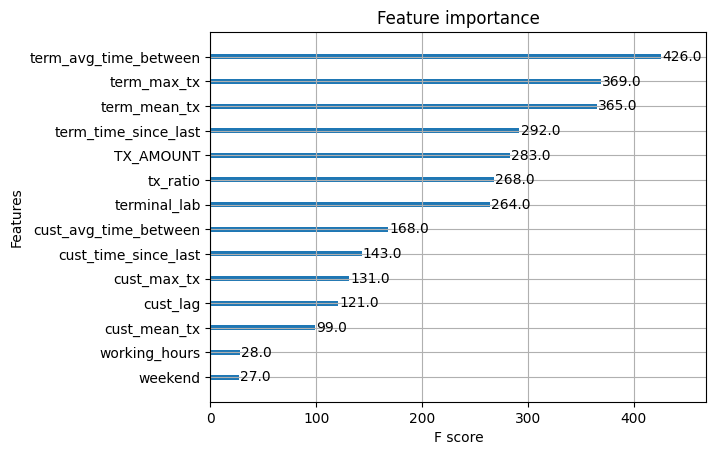

In [67]:
plot_importance(xg_model)
plt.show()

In [143]:
xg_model.feature_importances_

array([0.85499656, 0.00245165, 0.0025338 , 0.00397552, 0.00324019,
       0.00284018, 0.00342749, 0.02185736, 0.01850681, 0.02071469,
       0.02563081, 0.00349357, 0.03346648, 0.0028648 ], dtype=float32)